In [2]:
from hnn_core import simulate_dipole, calcium_model, MPIBackend, read_params, jones_2009_model
import os.path as op
import hnn_core
from hnn_core.viz import plot_dipole
import matplotlib.pyplot as plt
import numpy as np
from utils import add_supra_beta_drives, rescale_pyr_morph, add_law_beta_drives, rescale_pyr_mech
import seaborn as sns
sns.set()
sns.set_style("whitegrid")


In [3]:
depths = np.arange(-325, 2150, 100) 
electrode_pos = [(135, 135, dep) for dep in depths]
scaling_factors = [1, .8, .28]
#props = ['L', 'diam', 'Ra', 'cm']
props = ['L']
mech_edits = [('hh2', 'gkbar_hh2'), ('hh2', 'gnabar_hh2'), ('ca', 'gbar_ca'), ('cad', 'taur_cad'), ('kca', 'gbar_kca'), ('km', 'gbar_km'), ('cat', 'gbar_cat')]
pyr_cells = ['L2_pyramidal', 'L5_pyramidal']
omit_compartments = ['basal_1',  'basal_2',  'basal_3',  'soma']

net = calcium_model()
net.add_electrode_array('shank1', electrode_pos)
add_supra_beta_drives(net, beta_start=200, strength=1.0)

                    
with MPIBackend(n_procs=8):
    dpl = simulate_dipole(net, tstop=500, dt=0.05)[0]

dpl.data['agg']  -= dpl.data['agg'][int(100/0.05)] # subtract baseline at 100 ms (assuming dt=0.05)


MPI will run over 8 processes
Running 1 trials...
numprocs=8
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
Loading custom mechanism files from /home/ntolley/Jones_Lab/hnn-core/hnn_core/mod/x86_64/.libs/libnrnmech.so
[Done]
running trial 1 on 8 cores
Simulat

<ipython-input-6-cec13e02d51f>:27: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


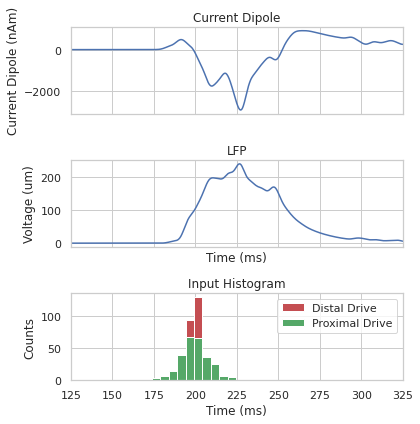

In [6]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(6, 6), constrained_layout=True)
scale = 0.7e5

tstart, tstop = 125, 325
times = dpl.times
contact_idx1 = 4
idx = 0
times_mask = np.logical_and(times < tstop, times > tstart)

axes[0].plot(times[times_mask], dpl.copy().smooth(window_len=10).data['agg'][times_mask] * scale)
axes[0].set_title(f'Current Dipole')
axes[0].set_ylabel('Current Dipole (nAm)')

lfp1 = net.rec_arrays['shank1'].copy().smooth(window_len=10).voltages.squeeze()[contact_idx1, times_mask]
axes[1].plot(times[times_mask], lfp1 - lfp1[0])
axes[1].set_title('LFP')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Voltage (um)')


net.cell_response.plot_spikes_hist(ax=axes[2], show=False)
axes[2].set_title('Input Histogram')
axes[2].set_xlabel('Time (ms)')

axes[2].set_xlim([tstart, tstop])

plt.tight_layout()
plt.savefig('final_figures/calcium_dipole_lfp.eps')
plt.savefig('final_figures/calcium_dipole_lfp.png')



In [7]:
np.savetxt('calcium_beta_lfp_smooth_10ms.csv', lfp1, delimiter=',')

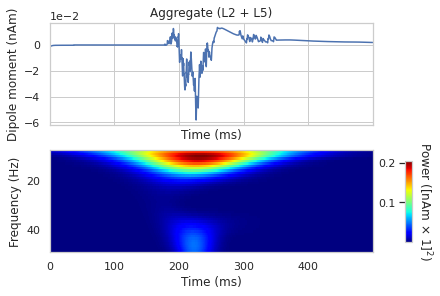

In [4]:
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 4), constrained_layout=True)
plot_dipole(dpl, ax=axes[0], show=False)
freqs = np.arange(8, 50)
dpl.copy().plot_tfr_morlet(freqs, ax=axes[1], show=False, colormap='jet')
axes[1].set_ylim(axes[idx+1].get_ylim()[::-1])
fig.savefig(f'final_figures/calcium_spectrogram_dipole.eps')
fig.savefig(f'final_figures/calcium_spectrogram_dipole.png')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


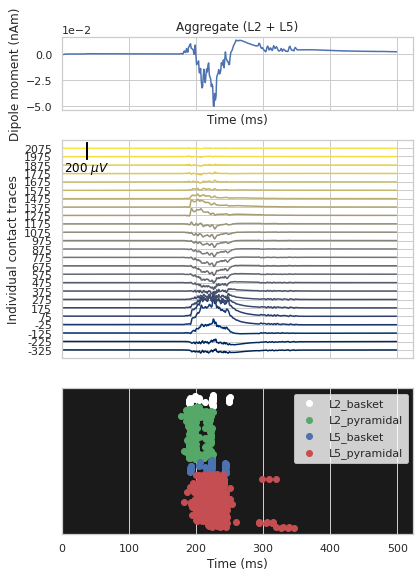

In [5]:
trial_idx = 0
res_idx = 0
scale = 0.7e5

window_len = 1  # ms
decimate = [5, 4]  # from 40k to 8k to 2k

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 8),
                        gridspec_kw={'height_ratios': [1, 3, 2]})

# Then plot the aggregate dipole time series on its own axis
dpl.copy().smooth(
    window_len=window_len).plot(ax=axs[0], decim=decimate,
                                show=False)

voltage_offset = 100  # the spacing between individual traces
voltage_scalebar = 200  # can be different from offset
# we can assign each electrode a unique color using a linear colormap
colors = plt.get_cmap('cividis', len(electrode_pos))

# use the same smoothing window on the LFP traces to allow comparison to dipole
net.rec_arrays['shank1'].copy().smooth(window_len=window_len).plot(
    ax=axs[1], contact_labels=depths, color=colors, decim=decimate, show=False,
    voltage_offset=voltage_offset, voltage_scalebar=voltage_scalebar)

axs[1].grid(True, which='major', axis='x')
axs[1].set_xlabel('')
# Finally, add the spike raster to the bottom subplot
net.cell_response.plot_spikes_raster(ax=axs[2], show=False)
plt.tight_layout()
plt.savefig(f'final_figures/calcium_lfp_array.eps')
plt.savefig(f'final_figures/calcium_lfp_array.png')

In [7]:
net.rec_arrays

{'shank1': <ExtracellularArray | 25 electrodes, conductivity=0.3, method=psa | 1 trials, 10001 times>}